In [ ]:
#사전 작업
%pip install Faker
%pip install mysqlclient
%pip install sqlalchemy

In [ ]:
#dummy data 생성

from faker import Faker
import pandas as pd

fake = Faker()  # locale 정보 설정

def generate_user_data(n):
    data = []
    for _ in range(n):
        user_info = {
            "name": fake.name(),
            "email": fake.unique.free_email(),
            "address": fake.address(),
            "phone_number": fake.phone_number()
        }
        data.append(user_info)
    return data

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

data_sizes = [1000, 5000, 10000, 50000, 100000, 150000]

for size in data_sizes:
    user_data = generate_user_data(size)
    filename = f"test_data_{size}.csv"
    save_to_csv(user_data, filename)
    print(f"Generated and saved {size} user records to {filename}")

# 마지막 200000개 데이터도 같은 방식으로 생성
final_size = 200000
final_user_data = generate_user_data(final_size)
final_filename = f"test_data_{final_size}.csv"
save_to_csv(final_user_data, final_filename)
print(f"Generated and saved {final_size} user records to {final_filename}")



In [9]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#코어 확인용
%pip install psutil

In [1]:
# memory info
import psutil

# CPU 코어 수 확인
physical_cores = psutil.cpu_count(logical=False)
total_cores = psutil.cpu_count(logical=True)

# 메모리 용량 확인
memory = psutil.virtual_memory()

print(f"Physical cores: {physical_cores}")
print(f"Total cores: {total_cores}")
print(f"Total memory: {memory.total / (1024 ** 3):.2f} GB")


Physical cores: 12
Total cores: 16
Total memory: 15.69 GB


In [5]:
import time
from pyspark.sql import SparkSession
import pandas as pd

# Spark 세션 생성 시 옵션 설정
spark_start_time = time.time()
spark = SparkSession.builder \
    .appName("SparkVsPandas") \
    .config("spark.executor.memory", "5g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "3") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
spark_end_time = time.time()
spark_initialization_time = spark_end_time - spark_start_time

def load_csv_spark(filename):
    start_time = time.time()
    df = spark.read.csv(filename, header=True, inferSchema=True)
    end_time = time.time()
    load_time = end_time - start_time
    return df, load_time

def unique_addresses_spark(df):
    start_time = time.time()
    address_groups = df.groupBy('address').count().collect()
    end_time = time.time()
    process_time = end_time - start_time
    return address_groups, process_time

def main_spark():
    total_start_time = time.time()
    time_spark = []

    filenames = [
        "test_data_1000.csv",
        "test_data_5000.csv",
        "test_data_10000.csv",
        "test_data_50000.csv",
        "test_data_100000.csv",
        "test_data_150000.csv",
        "test_data_200000.csv",
    ]
    
    for filename in filenames:
        df, load_time = load_csv_spark(filename)
        address_groups, process_time = unique_addresses_spark(df)
        
        total_time = load_time + process_time
        size = int(filename.split('_')[2].split('.')[0])
        time_spark.append([size, total_time])
        print(f"Total time for {filename} using Spark: {total_time:.4f} seconds")
    
    total_end_time = time.time()
    total_exec_time = total_end_time - total_start_time
    print(f"Total execution time using Spark: {total_exec_time:.4f} seconds")
    print(f"Spark initialization time: {spark_initialization_time:.4f} seconds")
    
    df_time_spark = pd.DataFrame(time_spark, columns=['Dataset Size', 'Time (seconds)'])
    df_time_spark.to_csv("time_spark.csv", index=False)
    print(df_time_spark)

    # Spark 세션 종료
    spark.stop()

if __name__ == "__main__":
    main_spark()


Total time for test_data_1000.csv using Spark: 0.5692 seconds
Total time for test_data_5000.csv using Spark: 0.6365 seconds
Total time for test_data_10000.csv using Spark: 0.5966 seconds
Total time for test_data_50000.csv using Spark: 1.1056 seconds
Total time for test_data_100000.csv using Spark: 1.4380 seconds
Total time for test_data_150000.csv using Spark: 1.9193 seconds
Total time for test_data_200000.csv using Spark: 1.9985 seconds
Total execution time using Spark: 8.3067 seconds
Spark initialization time: 0.1598 seconds
   Dataset Size  Time (seconds)
0          1000        0.569217
1          5000        0.636466
2         10000        0.596579
3         50000        1.105626
4        100000        1.438022
5        150000        1.919268
6        200000        1.998466


In [8]:
import pandas as pd
import time

# CSV 파일 불러오기
def load_csv_pandas(filename):
    start_time = time.time()
    df = pd.read_csv(filename)
    end_time = time.time()
    load_time = end_time - start_time
    return df, load_time

# Address 중복 제거 및 분류 작업
def unique_addresses_pandas(df):
    start_time = time.time()
    unique_addresses = df['address'].unique()
    address_groups = {address: df[df['address'] == address] for address in unique_addresses}
    end_time = time.time()
    process_time = end_time - start_time
    return address_groups, process_time

# 전체 실행 흐름
def main_pandas():
    total_start_time = time.time()
    time_pandas = []

    filenames = [
        #"test_data_1000.csv",
        #"test_data_5000.csv",
        #"test_data_10000.csv",
        #"test_data_50000.csv",
        #"test_data_100000.csv",
        "test_data_150000.csv",
        "test_data_200000.csv",
    ]
    
    for filename in filenames:
        df, load_time = load_csv_pandas(filename)
        address_groups, process_time = unique_addresses_pandas(df)
        
        total_time = load_time + process_time
        size = int(filename.split('_')[2].split('.')[0])
        time_pandas.append([size, total_time])
        print(f"Total time for {filename} using Pandas: {total_time:.4f} seconds")
    
    total_end_time = time.time()
    total_exec_time = total_end_time - total_start_time
    print(f"Total execution time using Pandas: {total_exec_time:.4f} seconds")
    
    # DataFrame 생성
    df_time_pandas = pd.DataFrame(time_pandas, columns=['Dataset Size', 'Time (seconds)'])
    df_time_pandas.to_csv("time_pandas.csv", index=False)
    print(df_time_pandas)

if __name__ == "__main__":
    main_pandas()


KeyboardInterrupt: 

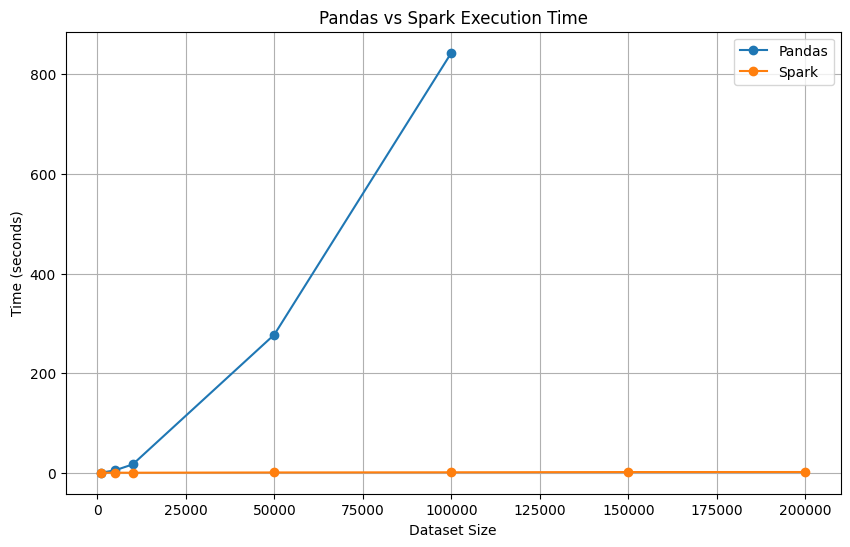

In [13]:
import pandas as pd
from matplotlib import pyplot as plt

def load_csv_pandas(filename):
    return pd.read_csv(filename)

# 데이터 불러오기
spark_time_data = load_csv_pandas("time_spark.csv")
pandas_time_data = load_csv_pandas("time_pandas.csv")

# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))

# Pandas 시간 데이터
plt.plot(pandas_time_data['Dataset Size'], pandas_time_data['Time (seconds)'], label='Pandas', marker='o')

# Spark 시간 데이터
plt.plot(spark_time_data['Dataset Size'], spark_time_data['Time (seconds)'], label='Spark', marker='o')

# 그래프 레이블 설정
plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.title('Pandas vs Spark Execution Time')
plt.legend()

# 그래프 표시
plt.grid(True)
plt.show()


(   Dataset Size  Time (seconds)
0          1000          0.5816
1          5000          5.3866
2         10000         17.3161
3         50000        277.8150
4        100000        843.4168
5        150000          0.0000
6        200000          0.0000, 0.007959127426147461)
